# 1.0 Imports

### 1.1 Libs

In [1]:
import numpy      as np
import pandas     as pd
import seaborn    as sns
import scikitplot as skplt
import xgboost    as xgb
import pickle
import warnings
warnings.filterwarnings('ignore')
from matplotlib        import pyplot          as plt
from sklearn           import preprocessing   as pp
from sklearn           import model_selection as ms
from sklearn           import ensemble        as en
from sklearn           import tree            as tr
from sklearn           import metrics         as mt
from sklearn           import linear_model    as lm
from sklearn.neighbors import KNeighborsClassifier
from imblearn.combine  import SMOTETomek

### 1.2 Loading data

In [2]:
df_raw = pd.read_csv('../datasets/train.csv', low_memory=False)

In [3]:
df_raw

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,Male,74,1,26.0,1,1-2 Year,No,30170.0,26.0,88,0
381105,381106,Male,30,1,37.0,1,< 1 Year,No,40016.0,152.0,131,0
381106,381107,Male,21,1,30.0,1,< 1 Year,No,35118.0,160.0,161,0
381107,381108,Female,68,1,14.0,0,> 2 Years,Yes,44617.0,124.0,74,0


### 1.3 Functions

In [3]:
def scores(score_name, model):
    
    bal_acc = score_name['test_balanced_accuracy'].mean()
    precision = score_name['test_precision'].mean()
    recall = score_name['test_recall'].mean()
    f1 = score_name['test_f1'].mean()
    
    return pd.DataFrame({'Model': model,
                        'Balanced_Accuracy': bal_acc,
                        'Precision': precision,
                        'Recall': recall,
                        'F1 Score': f1}, index=[1]).round(3)


def precision_at_k(data, k):

    data = data.reset_index(drop=True)
    data['ranking'] = data.index + 1
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    return data.loc[k, 'precision_at_k']    


def recall_at_k(data, k):
    
    data = data.reset_index(drop=True)
    data['ranking'] = data.index + 1
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    
    return data.loc[k, 'recall_at_k']

# 2.0 Descrição dos dados

In [4]:
df1 = df_raw.copy()

In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


### 2.1 Renomear colunas

In [5]:
cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age',
            'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage', 'response']

df1.columns = cols_new

### 2.2 Change types

In [6]:
df1['region_code'] = df1['region_code'].astype(int)
df1['policy_sales_channel'] = df1['policy_sales_channel'].astype(int)

### 2.3 Check NA 

In [7]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

### 2.4 Linhas duplicadas

In [8]:
linhas_duplicadas = df1[df1.duplicated()]
print("Linhas duplicadas:")
print(linhas_duplicadas)

Linhas duplicadas:
Empty DataFrame
Columns: [id, gender, age, driving_license, region_code, previously_insured, vehicle_age, vehicle_damage, annual_premium, policy_sales_channel, vintage, response]
Index: []


### 2.5 Estatística descritiva

In [16]:
stat_desc = df1.describe().T
stat_desc

,count,mean,std,min,25%,50%,75%,max
id,381109.0,190555.000000,110016.836208,1.0,95278.0,190555.0,285832.0,381109.0
age,381109.0,38.822584,15.511611,20.0,25.0,36.0,49.0,85.0
driving_license,381109.0,0.997869,0.046110,0.0,1.0,1.0,1.0,1.0
region_code,381109.0,26.388807,13.229888,0.0,15.0,28.0,35.0,52.0
previously_insured,381109.0,0.458210,0.498251,0.0,0.0,0.0,1.0,1.0
annual_premium,381109.0,30564.389581,17213.155057,2630.0,24405.0,31669.0,39400.0,540165.0
policy_sales_channel,381109.0,112.034295,54.203995,1.0,29.0,133.0,152.0,163.0
vintage,381109.0,154.347397,83.671304,10.0,82.0,154.0,227.0,299.0
response,381109.0,0.122563,0.327936,0.0,0.0,0.0,0.0,1.0


In [7]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64'])

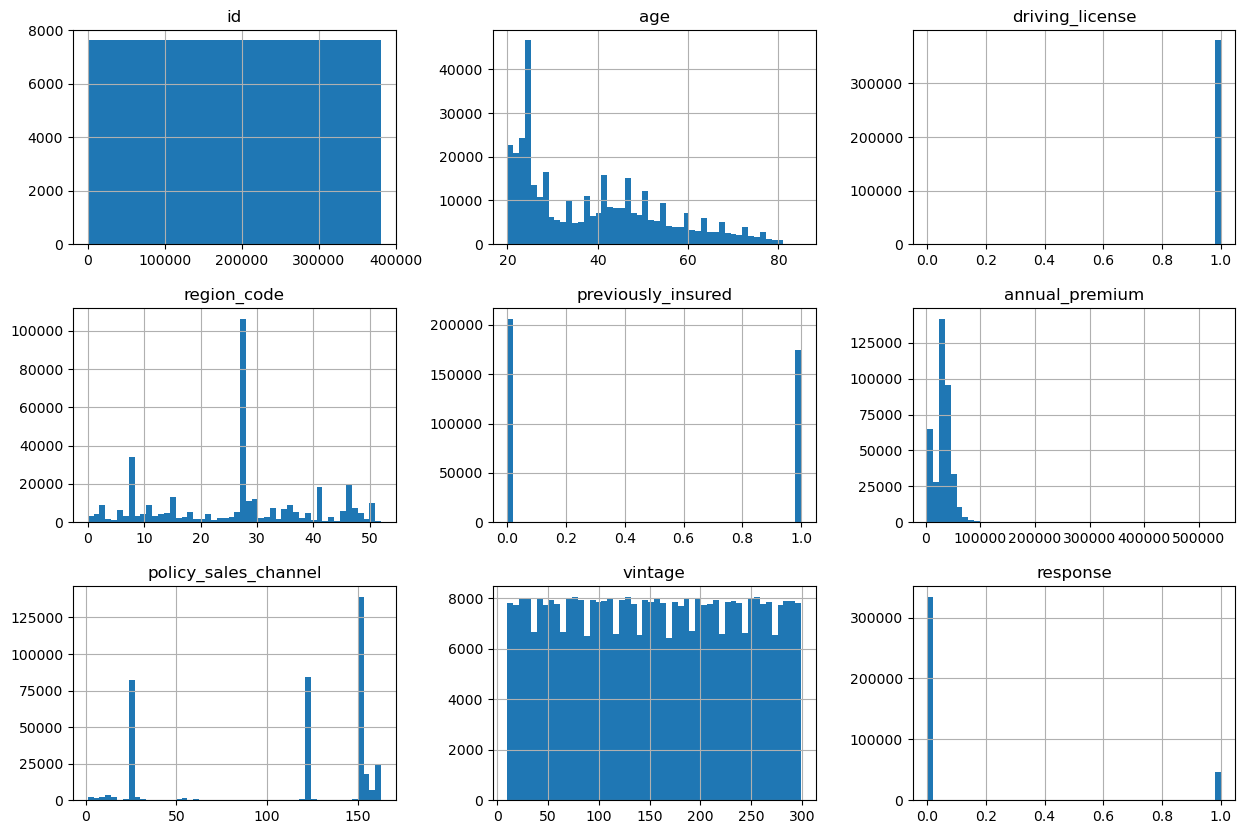

In [22]:
df1.hist(bins=50, figsize=(15,10));

In [71]:
cat_attributes.nunique()

gender            2
vehicle_age       3
vehicle_damage    2
dtype: int64

In [9]:
a = df1['gender'].unique()
b = df1['vehicle_age'].unique()
c = df1['vehicle_damage'].unique()

print(a, b, c)

['Male' 'Female'] ['> 2 Years' '1-2 Year' '< 1 Year'] ['Yes' 'No']


# 3.0 Análise exploratória dos dados

In [7]:
df2 = df1.copy()

### 3.1 Featuring engineering

In [8]:
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'over 2 years' if x == '> 2 Years' else '1-2 year' if x == '1-2 Year' else 'bellow 1 year')

### 3.2 Criação das hipóteses

In [ ]:
1 - Mulheres são mais propensas a aderirem ao seguro.
2 - Idosos são mais propensos a aderirem ao seguro.
3 - Quem não tem seguro-veículo é mais propenso a aderir ao seguro.
4 - Quem já bateu o carro é mais propenso a aderir ao seguro.
5 - Quem possui veículo novo é mais propenso a aderir ao seguro.
6 - Quem gasta mais com seguro-saúde é mais propenso a aderir ao seguro.
7 - Quem tem seguro a mais tempo é mais propenso a aderir ao seguro.
8 - Clientes de regiões específicas tem mais propensão a aderir ao seguro.
9 - Quem tem carteira de motorista tem mais propensão a aderir ao seguro.
10 - Meio de comunicação com o cliente afeta a propensão de aderir ao seguro.

In [ ]:
H1 - Mulheres são mais propensas a aderirem ao seguro. FALSA (tanto em número absoluto quanto em porcentagem)

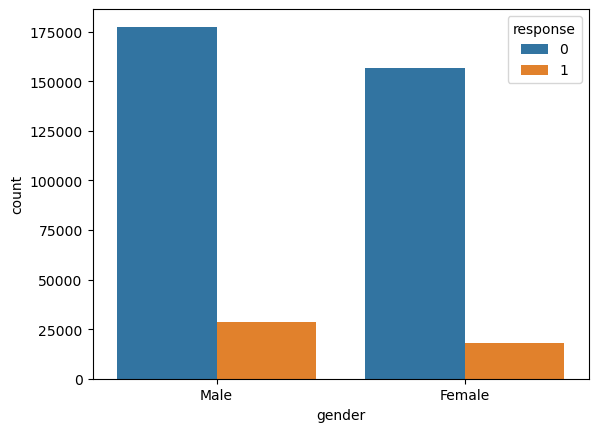

In [70]:
sns.countplot(data=df2, x='gender', hue='response');

In [ ]:
H2 - Idosos são mais propensos a aderirem ao seguro. FALSA (pessoas entre 40 e 50 anos são mais propensas)

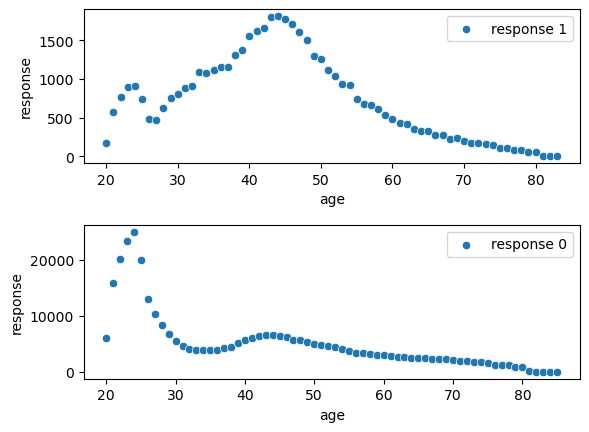

In [31]:
aux = df2[df2['response'] == 1]
aux1 = aux.groupby('age').count()
plt.subplot(2, 1, 1)
sns.scatterplot(x='age', y='response', data=aux1, label='response 1');

aux = df2[df2['response'] == 0]
aux1 = aux.groupby('age').count()
plt.subplot(2, 1, 2)
sns.scatterplot(x='age', y='response', data=aux1, label='response 0');
plt.subplots_adjust(hspace=0.4)

In [ ]:
H3 - Quem não tem seguro-veículo é mais propenso a aderir ao seguro. VERDADEIRA

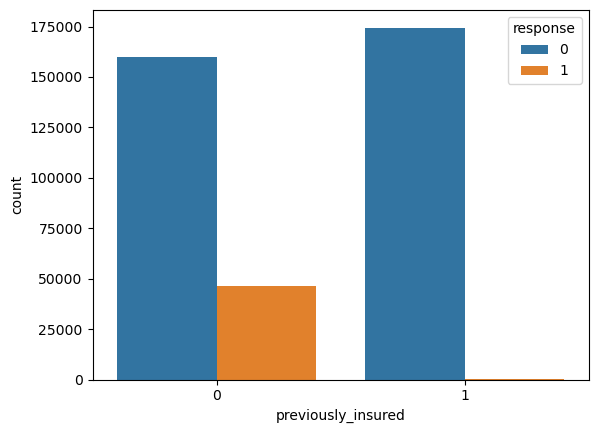

In [69]:
sns.countplot(data=df2, x='previously_insured', hue='response');

In [ ]:
H4 - Quem já teve algum incidente com carro é mais propenso a aderir ao seguro. VERDADEIRA

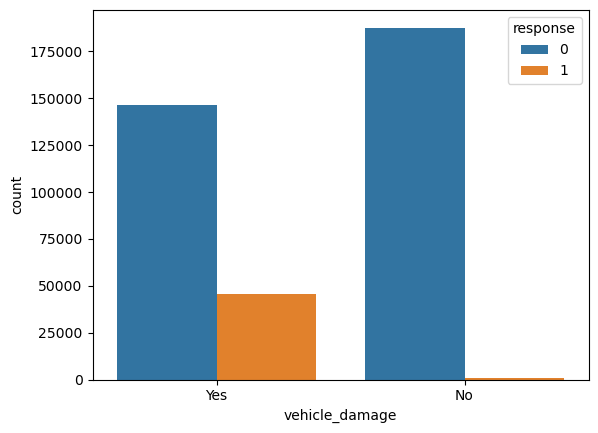

In [71]:
sns.countplot(data=df2, x='vehicle_damage', hue='response');

In [ ]:
H5 - Quem possui veículo novo é mais propenso a aderir ao seguro. FALSA (apesar de numericamente menor, proporcionalmente, 
quem tem veículos com mais de 2 anos são mais propensos a aderirem ao seguro)

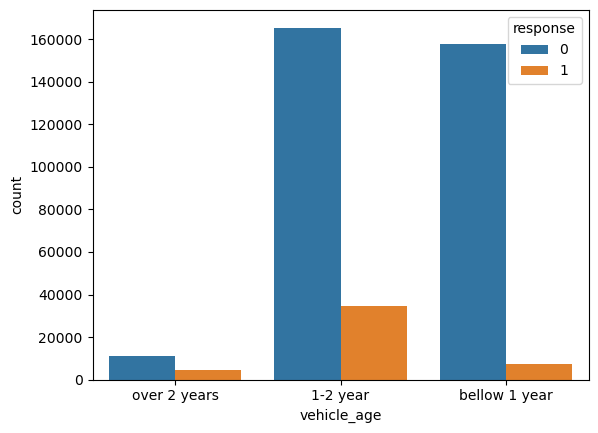

In [72]:
sns.countplot(data=df2, x='vehicle_age', hue='response');

In [ ]:
H6 - Quem gasta mais com seguro-saúde é mais propenso a aderir ao seguro. FALSA (quem gasta menos (2630.0) são mais propensos, 
seguidos por aqueles que gastam entre 20000 e 50000)

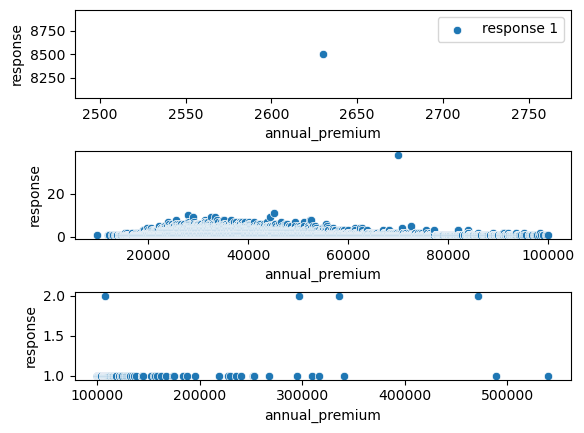

In [30]:
aux = df2[(df2['annual_premium'] < 3000.0) & (df2['response'] == 1)]
aux1 = aux.groupby('annual_premium').count()
plt.subplot(3, 1, 1);
sns.scatterplot(x='annual_premium', y='response', data=aux1, label='response 1');

aux = df2[(df2['annual_premium'] > 3000.0) & (df2['annual_premium'] < 100000.0) & (df2['response'] == 1)]
aux1 = aux.groupby('annual_premium').count()
plt.subplot(3, 1, 2);
sns.scatterplot(x='annual_premium', y='response', data=aux1);

aux = df2[(df2['annual_premium'] > 100000.0) & (df2['response'] == 1)]
aux1 = aux.groupby('annual_premium').count()
plt.subplot(3, 1, 3);
sns.scatterplot(x='annual_premium', y='response', data=aux1);
plt.subplots_adjust(hspace=0.6)

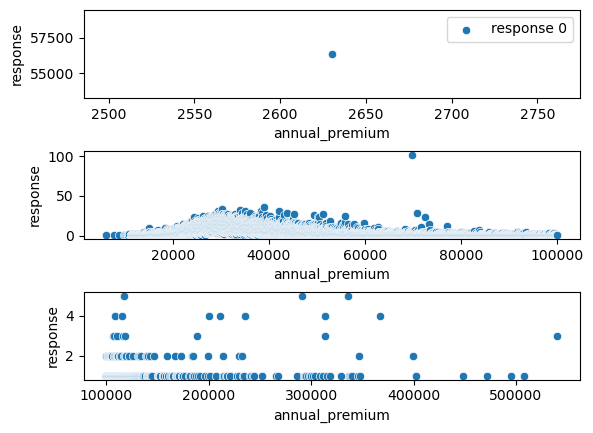

In [28]:
aux = df2[(df2['annual_premium'] < 3000.0) & (df2['response'] == 0)]
aux1 = aux.groupby('annual_premium').count()
plt.subplot(3, 1, 1);
sns.scatterplot(x='annual_premium', y='response', data=aux1, label='response 0');

aux = df2[(df2['annual_premium'] > 3000.0) & (df2['annual_premium'] < 100000.0) & (df2['response'] == 0)]
aux1 = aux.groupby('annual_premium').count()
plt.subplot(3, 1, 2);
sns.scatterplot(x='annual_premium', y='response', data=aux1);

aux = df2[(df2['annual_premium'] > 100000.0) & (df2['response'] == 0)]
aux1 = aux.groupby('annual_premium').count()
plt.subplot(3, 1, 3);
sns.scatterplot(x='annual_premium', y='response', data=aux1);
plt.subplots_adjust(hspace=0.6)

In [ ]:
H7 - Quem tem seguro a mais tempo é mais propenso a aderir ao seguro. FALSA (não parece haver relação entre as variáveis)

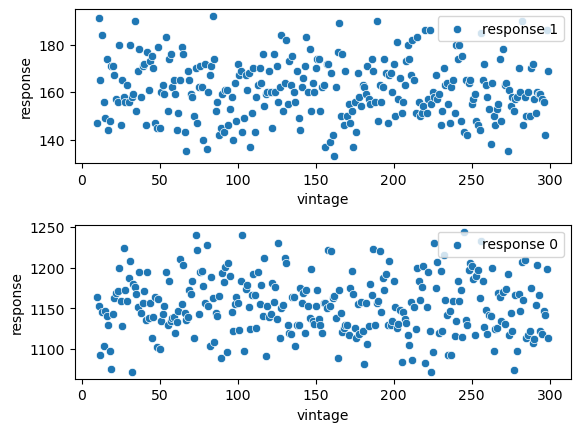

In [25]:
aux = df2[df2['response'] == 1]
aux1 = aux.groupby('vintage').count()
plt.subplot(2, 1, 1);
sns.scatterplot(x='vintage', y='response', data=aux1, label='response 1');

aux = df2[df2['response'] == 0]
aux1 = aux.groupby('vintage').count()
plt.subplot(2, 1, 2);
sns.scatterplot(x='vintage', y='response', data=aux1, label='response 0');
plt.subplots_adjust(hspace=0.4)

In [ ]:
H8 - Clientes de regiões específicas tem mais propensão a aderir ao seguro. FALSA (considerando que regiões com códigos próximos
estejam geograficamente próximas, não há relação. Algumas regiões apresentam melhores resultados, notavelmente a região 28, mas
não parece haver relação com a adesão ao seguro)

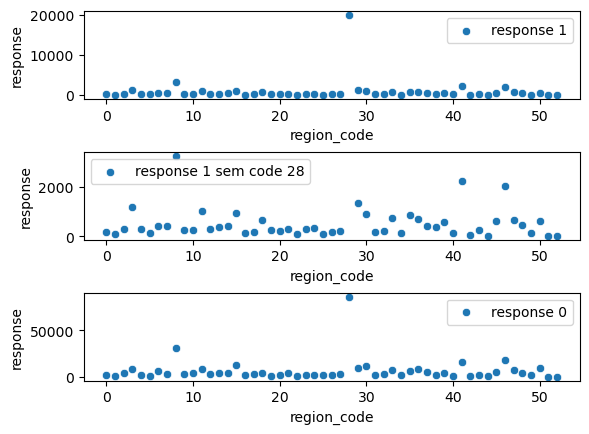

In [32]:
aux = df2[df2['response'] == 1]
aux1 = aux.groupby('region_code').count()
plt.subplot(3, 1, 1);
sns.scatterplot(x='region_code', y='response', data=aux1, label='response 1');

aux = df2[(df2['response'] == 1) & (df2['region_code'] != 28)]
aux1 = aux.groupby('region_code').count()
plt.subplot(3, 1, 2);
sns.scatterplot(x='region_code', y='response', data=aux1, label='response 1 sem code 28');

aux = df2[df2['response'] == 0]
aux1 = aux.groupby('region_code').count()
plt.subplot(3, 1, 3);
sns.scatterplot(x='region_code', y='response', data=aux1, label='response 0');
plt.subplots_adjust(hspace=0.6)

In [ ]:
H9 - Quem tem carteira de motorista tem mais propensão a aderir ao seguro. VERDADEIRA 

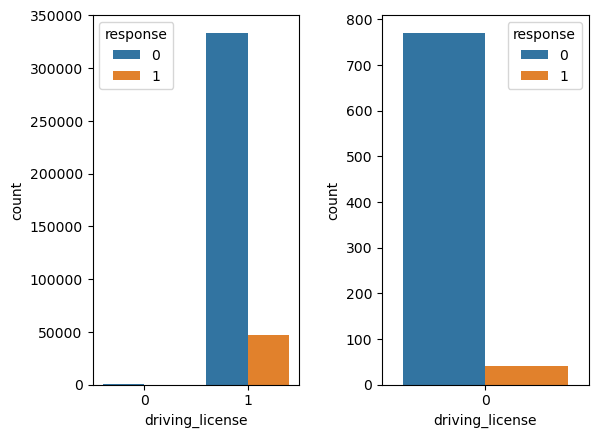

In [22]:
plt.subplot(1, 2, 1)
sns.countplot(data=df2, x='driving_license', hue='response');

plt.subplot(1, 2, 2)
aux = df2[(df2['driving_license'] == 0)]
sns.countplot(data=aux, x='driving_license', hue='response');
plt.subplots_adjust(wspace=0.4)

In [ ]:
H10 - Meio de comunicação com o cliente afeta a propensão de aderir ao seguro. VERDADEIRA (alguns tipo de comunicação tem 
resultados melhores)

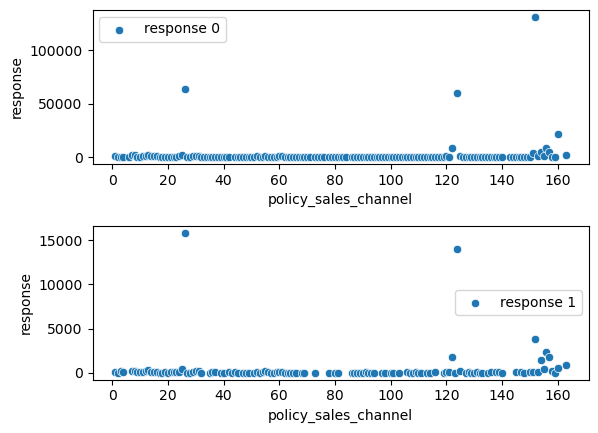

In [21]:
aux = df2[df2['response'] == 0]
aux1 = aux.groupby('policy_sales_channel').count()
plt.subplot(2, 1, 1);
sns.scatterplot(x='policy_sales_channel', y='response', data=aux1, label='response 0');

aux = df2[df2['response'] == 1]
aux1 = aux.groupby('policy_sales_channel').count()
plt.subplot(2, 1, 2);
sns.scatterplot(x='policy_sales_channel', y='response', data=aux1, label='response 1');
plt.subplots_adjust(hspace=0.4)

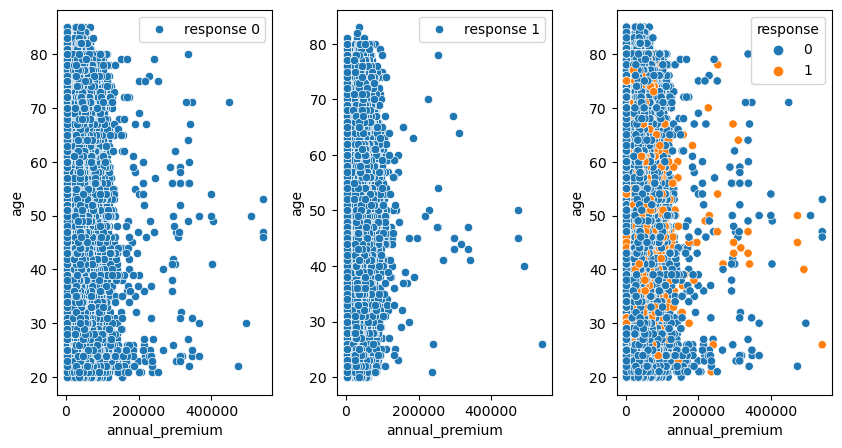

In [41]:
# Relação entre annual_premium e age:

plt.figure(figsize=(10, 5));
aux = df2[df2['response'] == 0]
plt.subplot(1, 3, 1)
sns.scatterplot(data=aux, x='annual_premium', y='age', label='response 0');

aux = df2[df2['response'] == 1]
plt.subplot(1, 3, 2)
sns.scatterplot(data=aux, x='annual_premium', y='age', label='response 1');

plt.subplot(1, 3, 3)
sns.scatterplot(data=df2, x='annual_premium', y='age', hue='response');

plt.subplots_adjust(wspace=0.3,hspace=0.1);

In [ ]:
Dos gráficos age x annual_premium: 
idosos tem annual_premium menores, 
há uma leve tendência que indica a diminuição do annual_premium com o aumento da idade

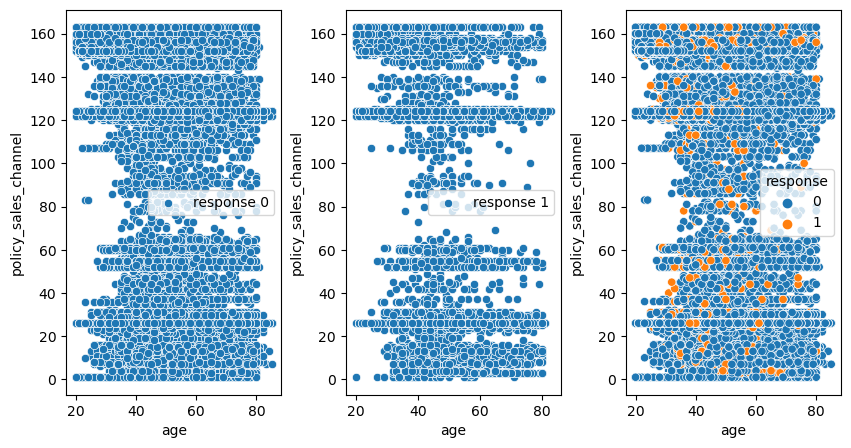

In [59]:
# Relação entre policy_sales_channel e age:

plt.figure(figsize=(10, 5));
aux = df2[df2['response'] == 0]
plt.subplot(1, 3, 1)
sns.scatterplot(data=aux, y='policy_sales_channel', x='age', label='response 0');

aux = df2[df2['response'] == 1]
plt.subplot(1, 3, 2)
sns.scatterplot(data=aux, y='policy_sales_channel', x='age', label='response 1');

plt.subplot(1, 3, 3)
sns.scatterplot(data=df2, y='policy_sales_channel', x='age', hue='response');

plt.subplots_adjust(wspace=0.3,hspace=0.1);

In [ ]:
Do gráfico policy_sales_channel x age:
há canais de comunicação que apresentaram resultados mais efetivos na adesão do seguro (indepedente da idade do cliente)

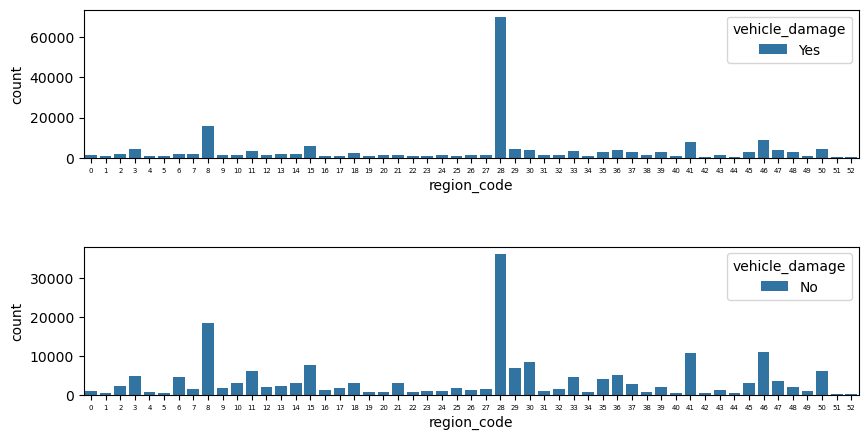

In [35]:
# Relação entre region_code e vehicle_damage:

plt.figure(figsize=(10, 5));
plt.rcParams['xtick.labelsize'] = 5
plt.rcParams['ytick.labelsize'] = 10
plt.subplot(2, 1, 1)
aux = df2[df2['vehicle_damage'] == 'Yes']
sns.countplot(data=aux, x='region_code', hue='vehicle_damage');

plt.subplot(2, 1, 2)
aux = df2[df2['vehicle_damage'] == 'No']
sns.countplot(data=aux, x='region_code', hue='vehicle_damage');

plt.subplots_adjust(wspace=0.1,hspace=0.6);

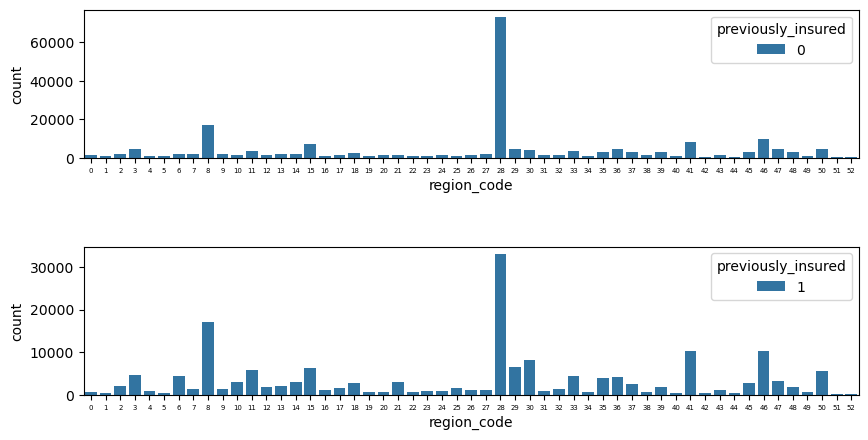

In [37]:
# Relação entre region_code e previously_insured:

plt.figure(figsize=(10, 5));
plt.rcParams['xtick.labelsize'] = 5
plt.rcParams['ytick.labelsize'] = 10
plt.subplot(2, 1, 1)
aux = df2[df2['previously_insured'] == 0]
sns.countplot(data=aux, x='region_code', hue='previously_insured');

plt.subplot(2, 1, 2)
aux = df2[df2['previously_insured'] == 1]
sns.countplot(data=aux, x='region_code', hue='previously_insured');

plt.subplots_adjust(wspace=0.1,hspace=0.6);

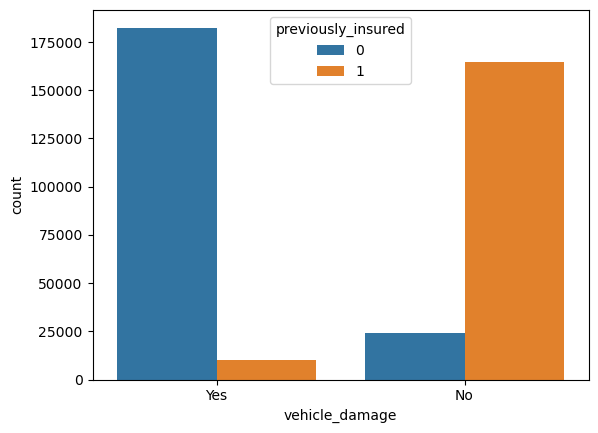

In [44]:
# Relação entre vehicle_damaged e previously_insured:

plt.rcParams['xtick.labelsize'] = 10
sns.countplot(data=df2, x='vehicle_damage', hue='previously_insured');

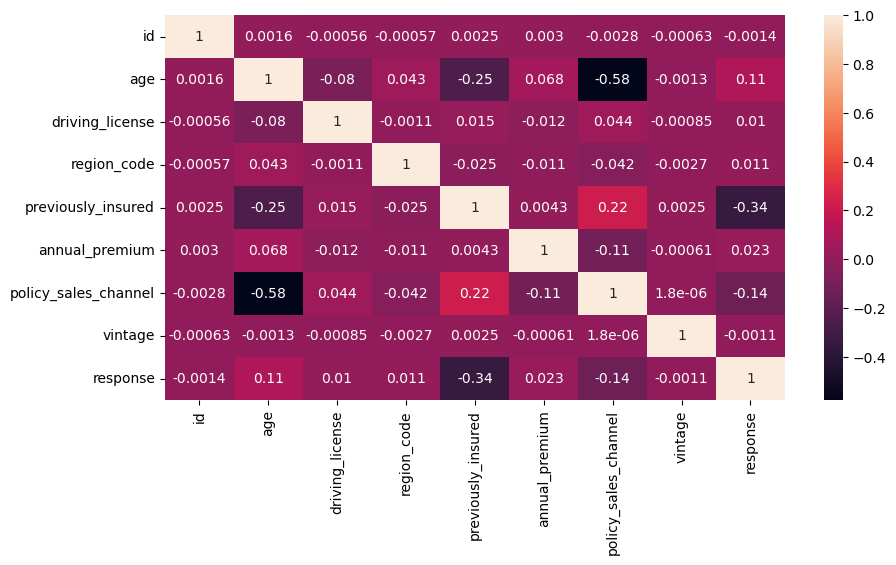

In [57]:
correlation = num_attributes.corr(method='pearson')
plt.figure(figsize=(10, 5));
sns.heatmap(correlation, annot=True);

In [9]:
df2['gender'] = df2['gender'].apply(lambda x: 1 if x == 'Male' else 0)
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

df2 = pd.get_dummies(df2, columns=['vehicle_age'], dtype=int)

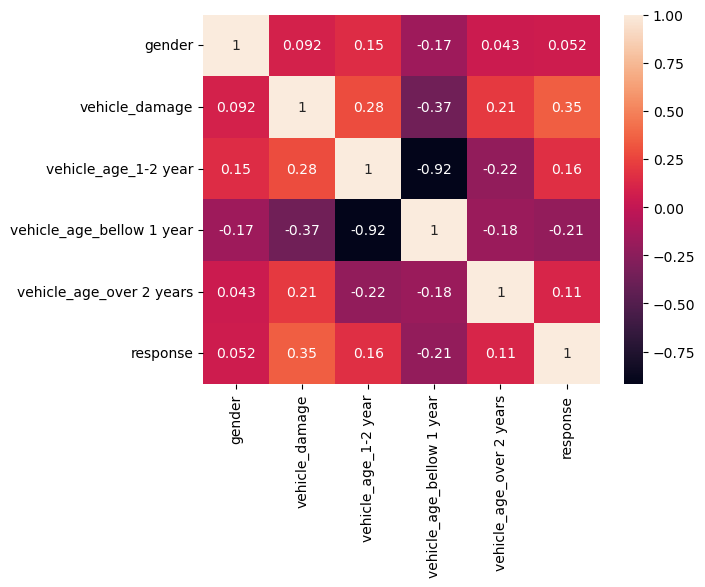

In [27]:
cat_attrib_featured = df2[['gender', 'vehicle_damage', 'vehicle_age_1-2 year', 'vehicle_age_bellow 1 year', 'vehicle_age_over 2 years', 'response']] 

correlation = cat_attrib_featured.corr(method='pearson')
sns.heatmap(correlation, annot=True);

# 4.0 Preparação dos dados

In [10]:
df3 = df2.copy()

### 4.1 Rescaling

In [11]:
ss = pp.StandardScaler()
df3['annual_premium'] = ss.fit_transform(df3[['annual_premium']].values)

mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()
df3['age'] = mms_age.fit_transform(df3[['age']].values)
df3['vintage'] = mms_vintage.fit_transform(df3[['vintage']].values)

### 4.2 Encoding

In [12]:
fe_policy_sales_channel = df3.groupby('policy_sales_channel').size() / len(df3) 
df3.loc[:, 'policy_sales_channel'] = df3['policy_sales_channel'].map(fe_policy_sales_channel)

fe_region_code = df3.groupby('region_code').size() / len(df3) 
df3.loc[:, 'region_code'] = df3['region_code'].map(fe_region_code)

### 4.3 Separação dos dados em train e validation 

In [13]:
X = df3.drop(['id', 'response'], axis=1)
y = df3['response'].copy() 

x_train, x_validation, y_train, y_validation = ms.train_test_split(X, y, test_size=0.20)

df4 = pd.concat([x_train, y_train], axis=1)

### 4.4 Feature selection

In [59]:
rf = en.RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(x_train, y_train)

rf.feature_importances_

array([0.00903692, 0.1442872 , 0.00050788, 0.1000255 , 0.04657772,
       0.07339015, 0.25331484, 0.07328729, 0.28318188, 0.00477526,
       0.00904237, 0.00257299])

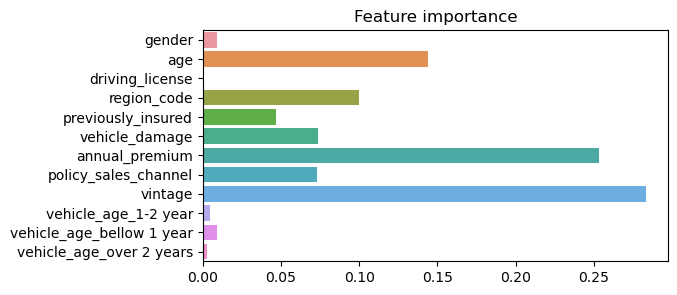

In [83]:
importances = pd.Series(data=rf.feature_importances_, index=x_train.columns)
plt.figure(figsize=(6, 3));
sns.barplot(x=importances, y=importances.index, orient='h').set_title('Feature importance');

# 5.0 Machine learning

In [14]:
cols_selected = ['age', 'region_code', 'previously_insured', 'vehicle_damage', 'annual_premium', 
                 'policy_sales_channel', 'vintage']

x_train = x_train[cols_selected]
x_validation = x_validation[cols_selected]

### 5.1 K-Nearest Neighbors

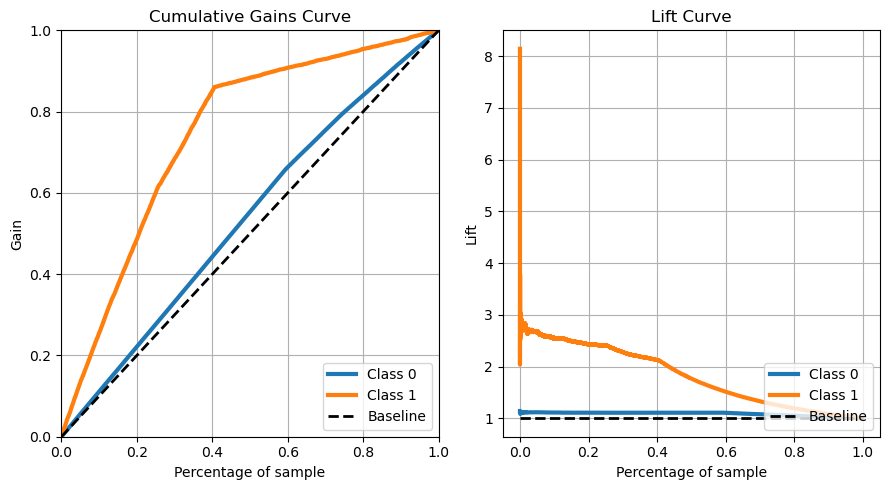

In [22]:
knn_classifier = KNeighborsClassifier(n_neighbors=7)
knn_classifier.fit(x_train, y_train)
yhat_knn = knn_classifier.predict_proba(x_validation)

fig, axes = plt.subplots(1, 2, figsize=(9, 5))
skplt.metrics.plot_cumulative_gain(y_validation, yhat_knn, ax=axes[0]);
skplt.metrics.plot_lift_curve(y_validation, yhat_knn, ax=axes[1]);
plt.tight_layout()
plt.show()

### 5.2 Decision Tree

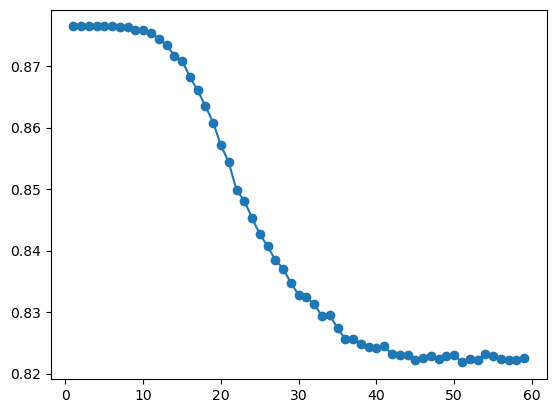

In [57]:
values = np.arange(1, 60, 1)
val_score = []

for i in values:
    tree = tr.DecisionTreeClassifier(max_depth=i)
    tree.fit(x_train, y_train)
    y_pred_val = tree.predict(x_validation)
    acc_val = mt.accuracy_score(y_validation, y_pred_val)
    val_score.append(acc_val)

plt.plot(values, val_score, '-o');

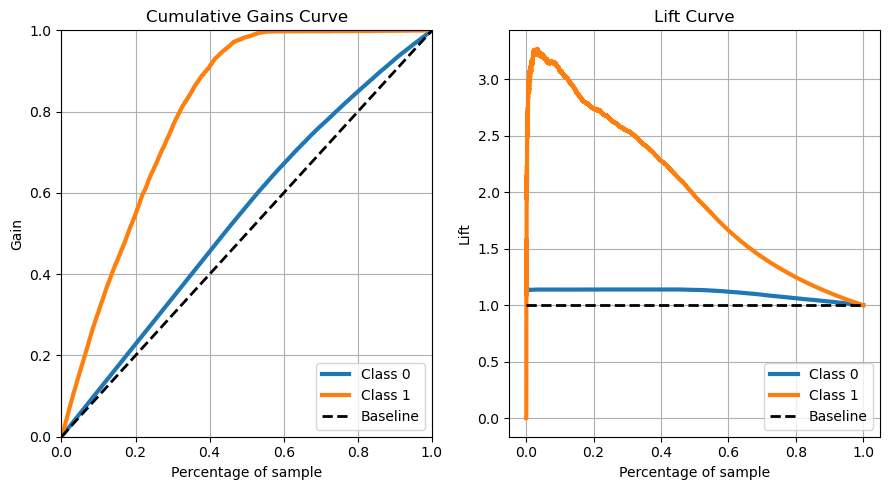

In [23]:
tree = tr.DecisionTreeClassifier(max_depth=8, random_state=42)
tree.fit(x_train, y_train)
yhat_tree = tree.predict_proba(x_validation)

fig, axes = plt.subplots(1, 2, figsize=(9, 5))
skplt.metrics.plot_cumulative_gain(y_validation, yhat_tree, ax=axes[0]);
skplt.metrics.plot_lift_curve(y_validation, yhat_tree, ax=axes[1]);
plt.tight_layout()
plt.show()

### 5.3 Random Forest

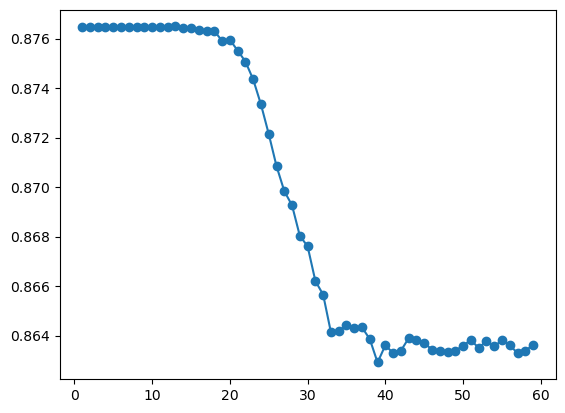

In [68]:
values = np.arange(1, 60, 1)
val_score = []

for i in values:
    random = en.RandomForestClassifier(max_depth=i, random_state=0)
    random.fit(x_train, y_train)
    y_pred_val = random.predict(x_validation)
    acc_val = mt.accuracy_score(y_validation, y_pred_val)
    val_score.append(acc_val)

plt.plot(values, val_score, '-o');

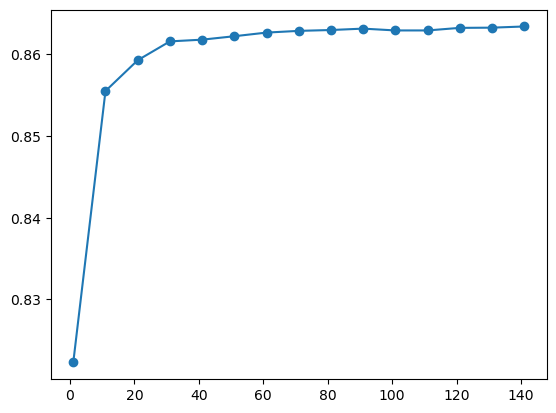

In [69]:
values = np.arange(1, 150, 10)
val_score = []

for i in values:
    random = en.RandomForestClassifier(n_estimators=i, random_state=0)
    random.fit(x_train, y_train)
    y_pred_val = random.predict(x_validation)
    acc_val = mt.accuracy_score(y_validation, y_pred_val)
    val_score.append(acc_val)

plt.plot(values, val_score, '-o');

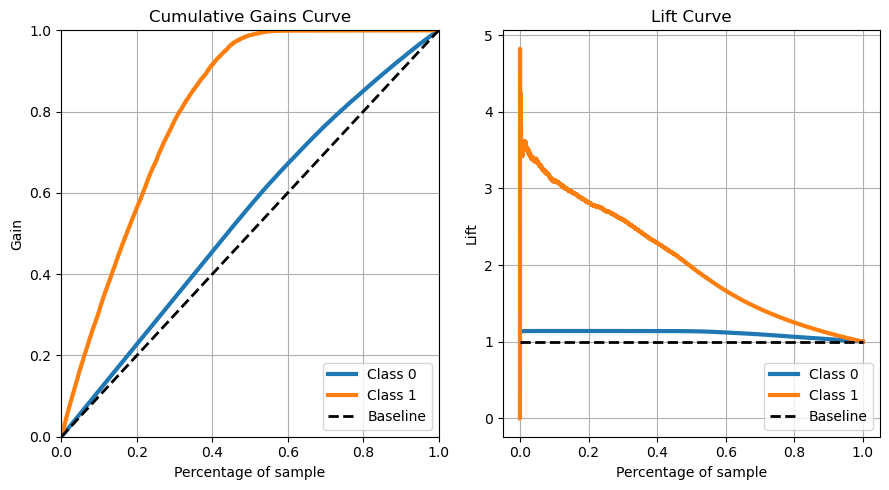

In [16]:
random = en.RandomForestClassifier(max_depth=13, n_estimators=140, random_state=0)
random.fit(x_train, y_train)
yhat_random = random.predict_proba(x_validation)

fig, axes = plt.subplots(1, 2, figsize=(9, 5))
skplt.metrics.plot_cumulative_gain(y_validation, yhat_random, ax=axes[0]);
skplt.metrics.plot_lift_curve(y_validation, yhat_random, ax=axes[1]);
plt.tight_layout()
plt.show()

### 5.4  Logistic Regression

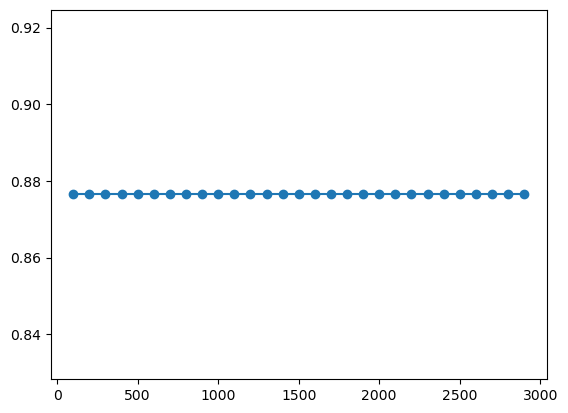

In [76]:
values = np.arange(100, 3000, 100)
val_score = []

for i in values:
    log_reg = lm.LogisticRegression(max_iter=i, random_state=0)
    log_reg.fit(x_train, y_train)
    y_pred_val = log_reg.predict(x_validation)
    acc_val = mt.accuracy_score(y_validation, y_pred_val)
    val_score.append(acc_val)

plt.plot(values, val_score, '-o');

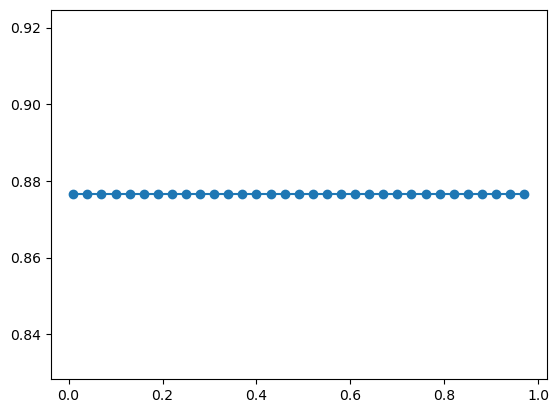

In [77]:
values = np.arange(0.01, 1.0, 0.03)
val_score = []

for i in values:
    log_reg = lm.LogisticRegression(C=i, random_state=0)
    log_reg.fit(x_train, y_train)
    y_pred_val = log_reg.predict(x_validation)
    acc_val = mt.accuracy_score(y_validation, y_pred_val)
    val_score.append(acc_val)

plt.plot(values, val_score, '-o');

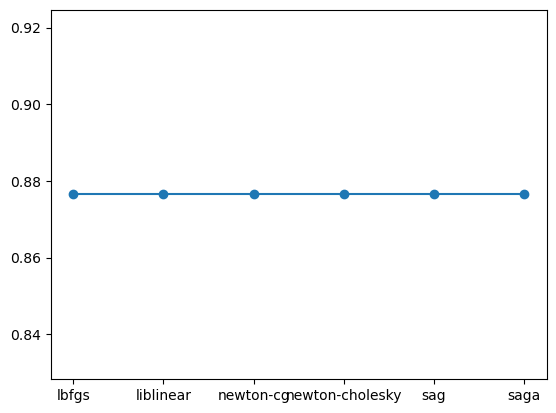

In [78]:
values = (['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'])
val_score = []

for i in values:
    log_reg = lm.LogisticRegression(solver=i, random_state=0)
    log_reg.fit(x_train, y_train)
    y_pred_val = log_reg.predict(x_validation)
    acc_val = mt.accuracy_score(y_validation, y_pred_val)
    val_score.append(acc_val)

plt.plot(values, val_score, '-o');

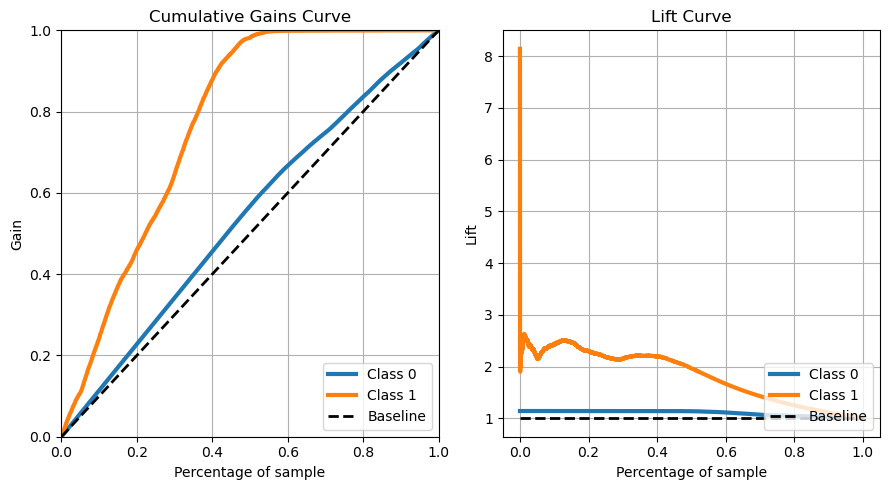

In [24]:
log_reg = lm.LogisticRegression(max_iter=1000, C=0.5, solver='newton-cg', random_state=0)
log_reg.fit(x_train, y_train)
yhat_log = log_reg.predict_proba(x_validation)

fig, axes = plt.subplots(1, 2, figsize=(9, 5))
skplt.metrics.plot_cumulative_gain(y_validation, yhat_log, ax=axes[0]);
skplt.metrics.plot_lift_curve(y_validation, yhat_log, ax=axes[1]);
plt.tight_layout()
plt.show()

### 5.5 Xgboost

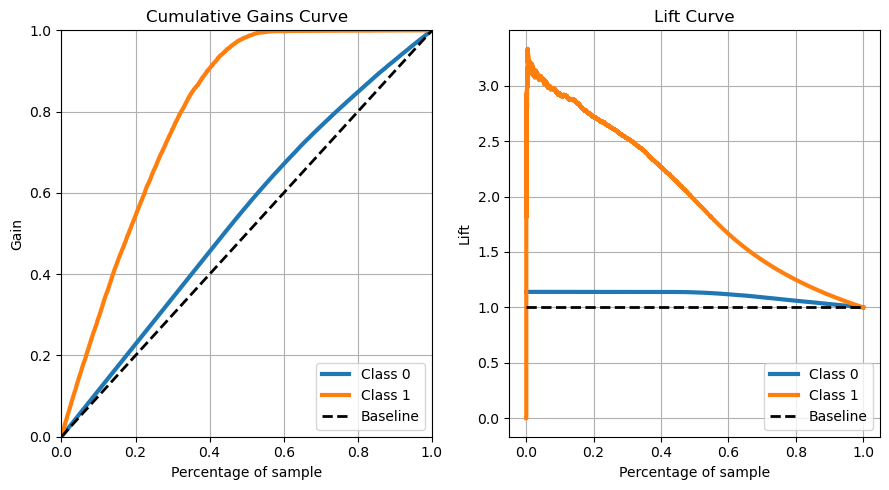

In [25]:
model_xgb = xgb.XGBClassifier(n_estimators=100, max_depth=10)
model_xgb.fit(x_train, y_train)
yhat_xgb = model_xgb.predict_proba(x_validation)

fig, axes = plt.subplots(1, 2, figsize=(9, 5))
skplt.metrics.plot_cumulative_gain(y_validation, yhat_xgb, ax=axes[0]);
skplt.metrics.plot_lift_curve(y_validation, yhat_xgb, ax=axes[1]);
plt.tight_layout()
plt.show()

### 5.6 ExtraTrees

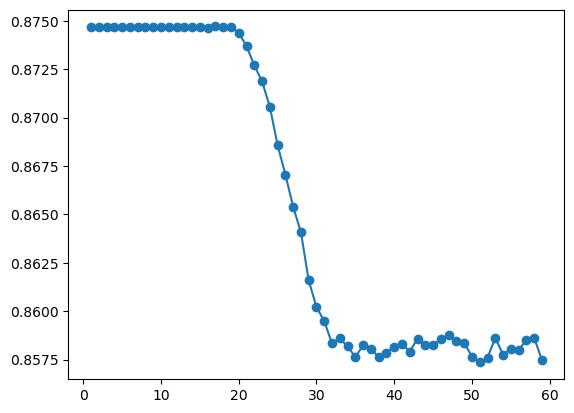

In [20]:
values = np.arange(1, 60, 1)
val_score = []

for i in values:
    model_et = en.ExtraTreesClassifier(max_depth=i, n_jobs=-1)
    model_et.fit(x_train, y_train)
    y_pred_val = model_et.predict(x_validation)
    acc_val = mt.accuracy_score(y_validation, y_pred_val)
    val_score.append(acc_val)

plt.plot(values, val_score, '-o');

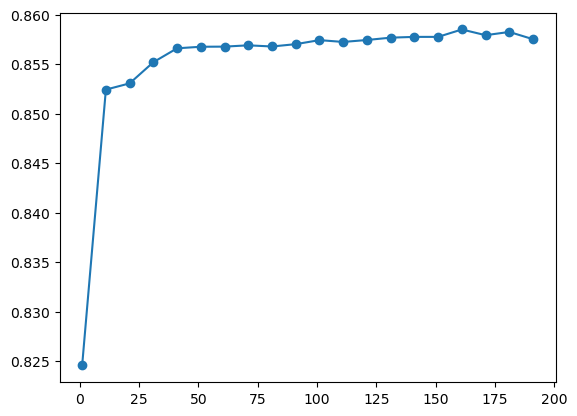

In [22]:
values = np.arange(1, 200, 10)
val_score = []

for i in values:
    model_et = en.ExtraTreesClassifier(n_estimators=i, n_jobs=-1)
    model_et.fit(x_train, y_train)
    y_pred_val = model_et.predict(x_validation)
    acc_val = mt.accuracy_score(y_validation, y_pred_val)
    val_score.append(acc_val)

plt.plot(values, val_score, '-o');

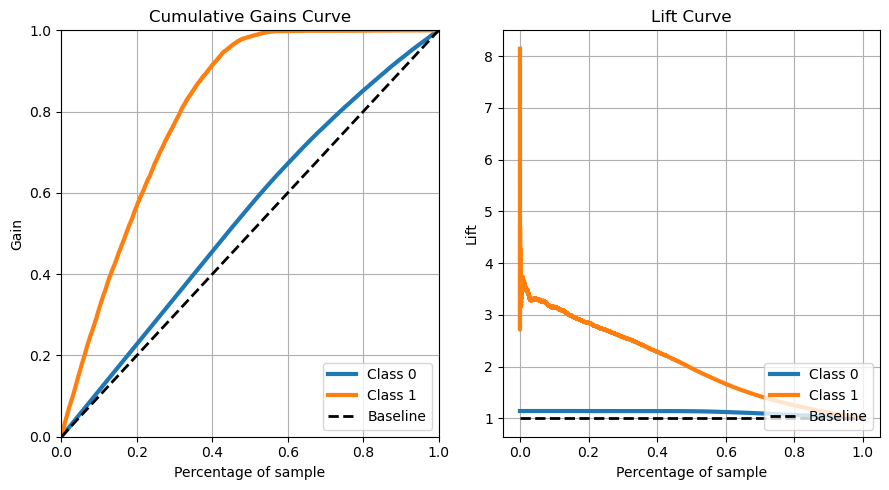

In [26]:
model_et = en.ExtraTreesClassifier(n_estimators=160, max_depth=17)
model_et.fit(x_train, y_train)
yhat_et = model_et.predict_proba(x_validation)

fig, axes = plt.subplots(1, 2, figsize=(9, 5))
skplt.metrics.plot_cumulative_gain(y_validation, yhat_et, ax=axes[0]);
skplt.metrics.plot_lift_curve(y_validation, yhat_et, ax=axes[1]);
plt.tight_layout()
plt.show()

### 5.7 Balanceando os dados --> Resampling a amostra

In [15]:
print('Antes balanceamento: {}'.format(y_train.value_counts()))

Antes balanceamento: response
0    267465
1     37422
Name: count, dtype: int64


In [15]:
x_train_res, y_train_res = SMOTETomek(random_state=0).fit_resample(x_train, y_train)

In [17]:
print('Depois balanceamento: {}'.format(y_train_res.value_counts()))

Depois balanceamento: response
0    262185
1    262185
Name: count, dtype: int64


In [16]:
x_train_res = x_train_res[cols_selected]

### 5.7.1 K-Nearest Neighbors Resampling

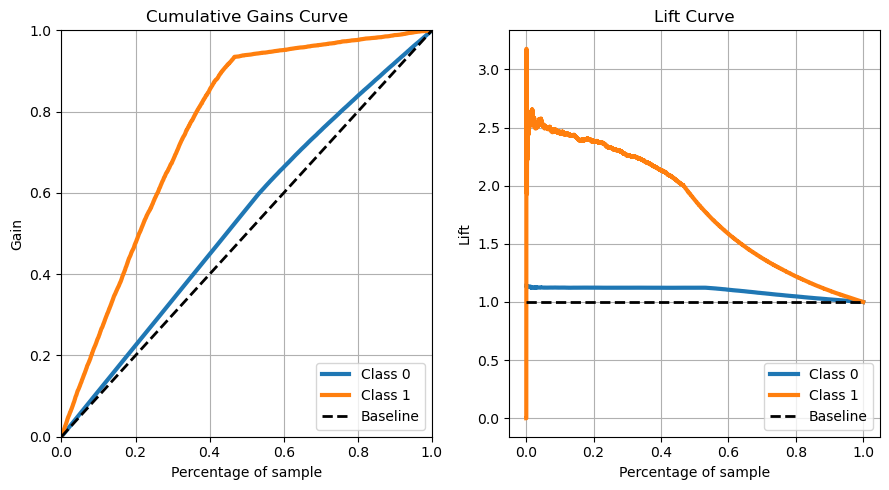

In [27]:
knn_classifier_res = KNeighborsClassifier(n_neighbors=9)
knn_classifier_res.fit(x_train_res, y_train_res)
yhat_knn_res = knn_classifier_res.predict_proba(x_validation)

fig, axes = plt.subplots(1, 2, figsize=(9, 5))
skplt.metrics.plot_cumulative_gain(y_validation, yhat_knn_res, ax=axes[0]);
skplt.metrics.plot_lift_curve(y_validation, yhat_knn_res, ax=axes[1]);
plt.tight_layout()
plt.show()

### 5.7.2 Decision Tree Resampling

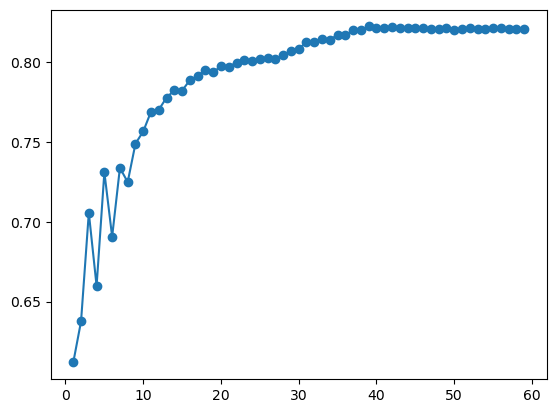

In [40]:
values = np.arange(1, 60, 1)
val_score = []

for i in values:
    tree_res = tr.DecisionTreeClassifier(max_depth=i)
    tree_res.fit(x_train_res, y_train_res)
    y_pred_val_res = tree_res.predict(x_validation)
    acc_val = mt.accuracy_score(y_validation, y_pred_val_res)
    val_score.append(acc_val)

plt.plot(values, val_score, '-o');

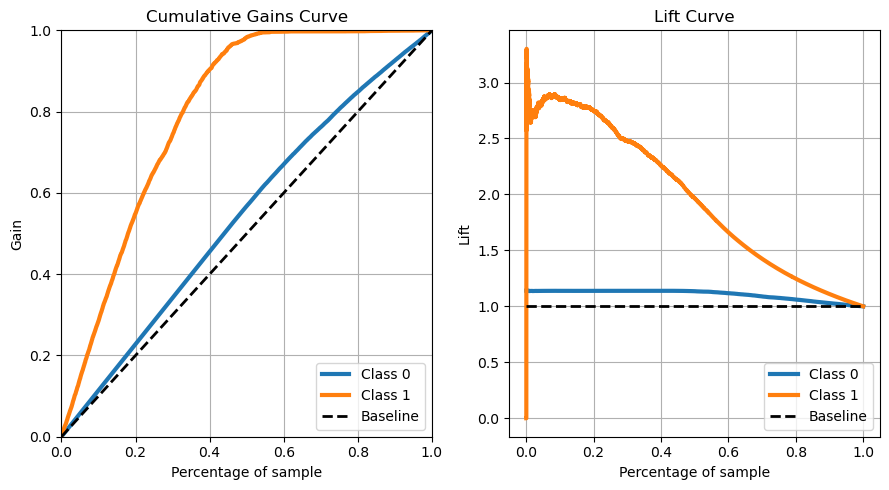

In [28]:
tree_res = tr.DecisionTreeClassifier(max_depth=10, random_state=42)
tree_res.fit(x_train_res, y_train_res)
yhat_tree_res = tree_res.predict_proba(x_validation)

fig, axes = plt.subplots(1, 2, figsize=(9, 5))
skplt.metrics.plot_cumulative_gain(y_validation, yhat_tree_res, ax=axes[0]);
skplt.metrics.plot_lift_curve(y_validation, yhat_tree_res, ax=axes[1]);
plt.tight_layout()
plt.show()

### 5.7.3 Random Forest Resampling

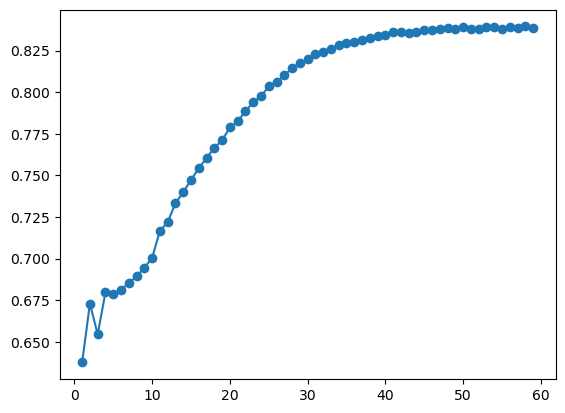

In [56]:
values = np.arange(1, 60, 1)
val_score = []

for i in values:
    random_res = en.RandomForestClassifier(max_depth=i, random_state=0)
    random_res.fit(x_train_res, y_train_res)
    y_pred_val_res = random_res.predict(x_validation)
    acc_val = mt.accuracy_score(y_validation, y_pred_val_res)
    val_score.append(acc_val)

plt.plot(values, val_score, '-o');

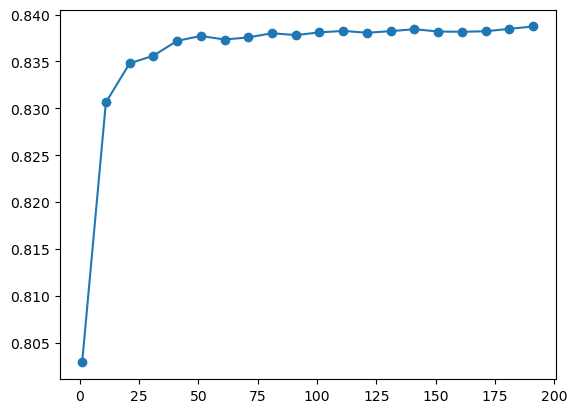

In [28]:
values = np.arange(1, 200, 10)
val_score = []

for i in values:
    random_res = en.RandomForestClassifier(n_estimators=i, random_state=0)
    random_res.fit(x_train_res, y_train_res)
    y_pred_val_res = random_res.predict(x_validation)
    acc_val = mt.accuracy_score(y_validation, y_pred_val_res)
    val_score.append(acc_val)

plt.plot(values, val_score, '-o');

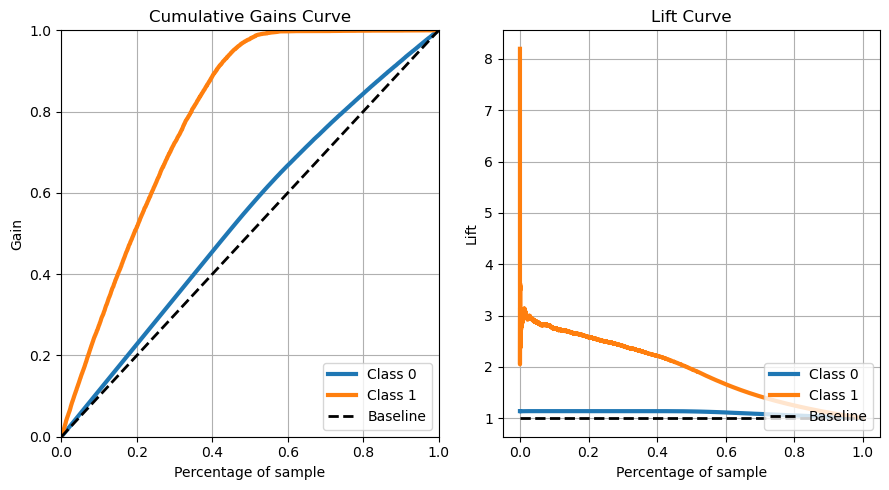

In [21]:
random_res = en.RandomForestClassifier(max_depth=59, n_estimators=190, random_state=0)
random_res.fit(x_train_res, y_train_res)
yhat_random_res = random_res.predict_proba(x_validation)

fig, axes = plt.subplots(1, 2, figsize=(9, 5))
skplt.metrics.plot_cumulative_gain(y_validation, yhat_random_res, ax=axes[0]);
skplt.metrics.plot_lift_curve(y_validation, yhat_random_res, ax=axes[1]);
plt.tight_layout()
plt.show()

### 5.7.4 Logistic Regression Resampling

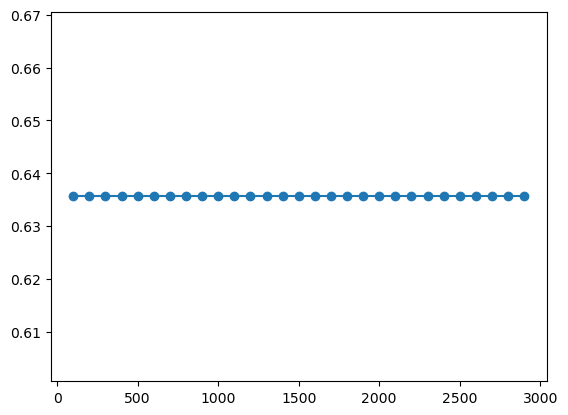

In [30]:
values = np.arange(100, 3000, 100)
val_score = []

for i in values:
    log_reg_res = lm.LogisticRegression(max_iter=i, random_state=0)
    log_reg_res.fit(x_train_res, y_train_res)
    y_pred_val_res = log_reg_res.predict(x_validation)
    acc_val = mt.accuracy_score(y_validation, y_pred_val_res)
    val_score.append(acc_val)

plt.plot(values, val_score, '-o');

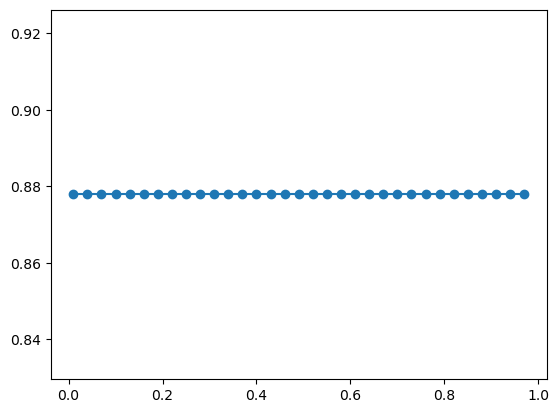

In [31]:
values = np.arange(0.01, 1.0, 0.03)
val_score = []

for i in values:
    log_reg_res = lm.LogisticRegression(C=i, random_state=0)
    log_reg_res.fit(x_train_res, y_train_res)
    y_pred_val_res = log_reg.predict(x_validation)
    acc_val = mt.accuracy_score(y_validation, y_pred_val_res)
    val_score.append(acc_val)

plt.plot(values, val_score, '-o');

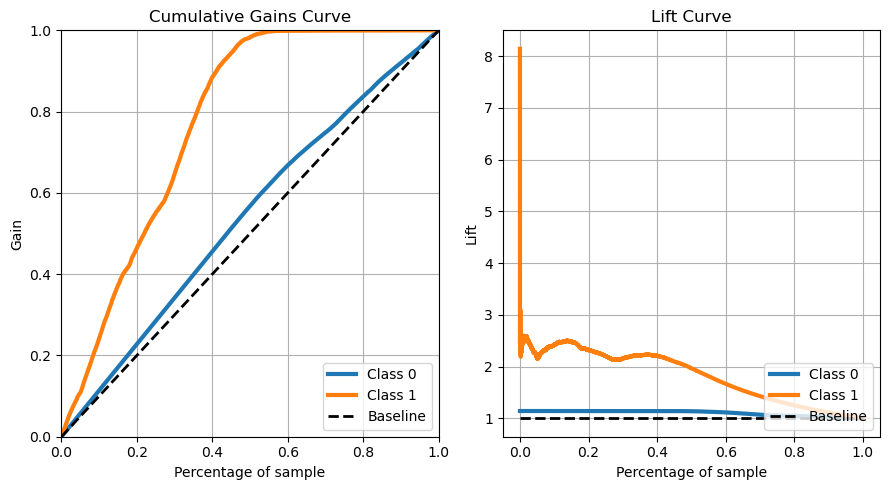

In [29]:
log_reg_res = lm.LogisticRegression(max_iter=1000, C=0.5, solver='newton-cg', random_state=0)
log_reg_res.fit(x_train_res, y_train_res)
yhat_log_res = log_reg_res.predict_proba(x_validation)

fig, axes = plt.subplots(1, 2, figsize=(9, 5))
skplt.metrics.plot_cumulative_gain(y_validation, yhat_log_res, ax=axes[0]);
skplt.metrics.plot_lift_curve(y_validation, yhat_log_res, ax=axes[1]);
plt.tight_layout()
plt.show()

### 5.7.5 XGBoost Resampling

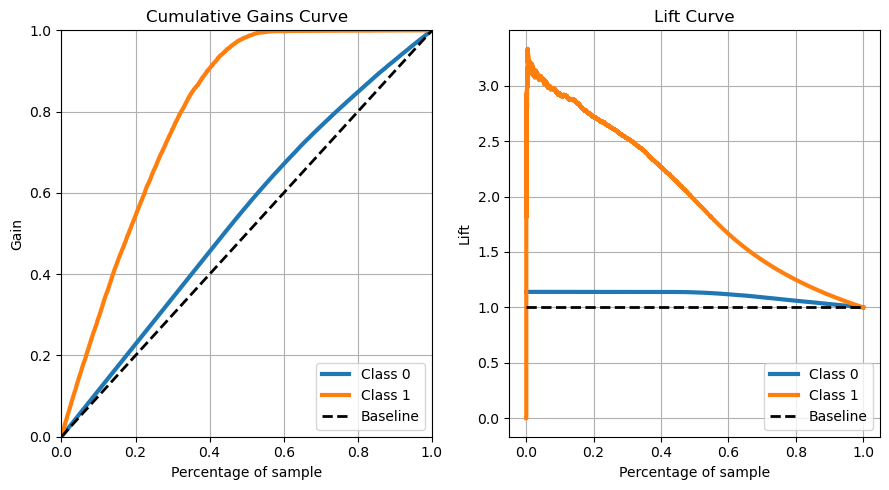

In [30]:
model_xgb_res = xgb.XGBClassifier(n_estimators=100, max_depth=10)
model_xgb_res.fit(x_train_res, y_train_res)
yhat_xgb_res = model_xgb.predict_proba(x_validation)

fig, axes = plt.subplots(1, 2, figsize=(9, 5))
skplt.metrics.plot_cumulative_gain(y_validation, yhat_xgb_res, ax=axes[0]);
skplt.metrics.plot_lift_curve(y_validation, yhat_xgb_res, ax=axes[1]);
plt.tight_layout()
plt.show()

### 5.7.6 ExtraTrees Resampling

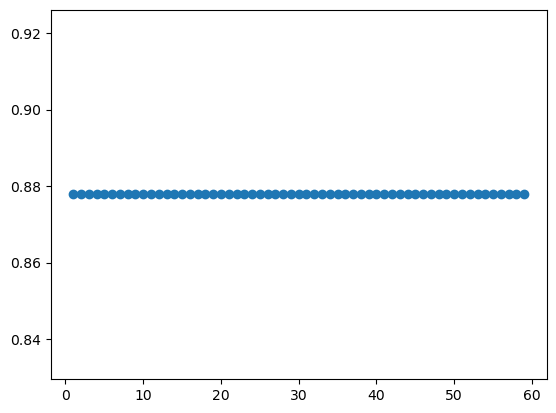

In [50]:
values = np.arange(1, 60, 1)
val_score = []

for i in values:
    model_et_res = en.ExtraTreesClassifier(max_depth=i, n_jobs=-1)
    model_et_res.fit(x_train_res, y_train_res)
    y_pred_val_res = model_et.predict(x_validation)
    acc_val = mt.accuracy_score(y_validation, y_pred_val_res)
    val_score.append(acc_val)

plt.plot(values, val_score, '-o');

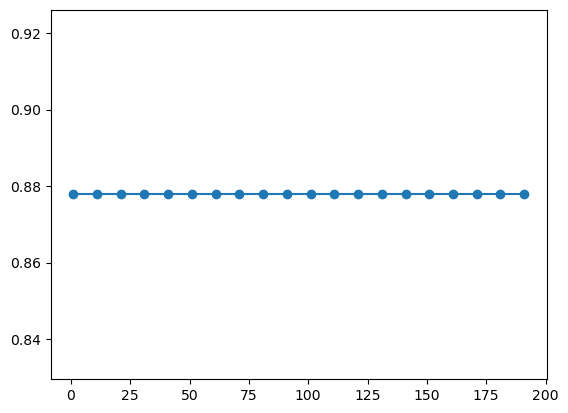

In [51]:
values = np.arange(1, 200, 10)
val_score = []

for i in values:
    model_et_res = en.ExtraTreesClassifier(n_estimators=i, n_jobs=-1)
    model_et_res.fit(x_train_res, y_train_res)
    y_pred_val_res = model_et.predict(x_validation)
    acc_val = mt.accuracy_score(y_validation, y_pred_val_res)
    val_score.append(acc_val)

plt.plot(values, val_score, '-o');

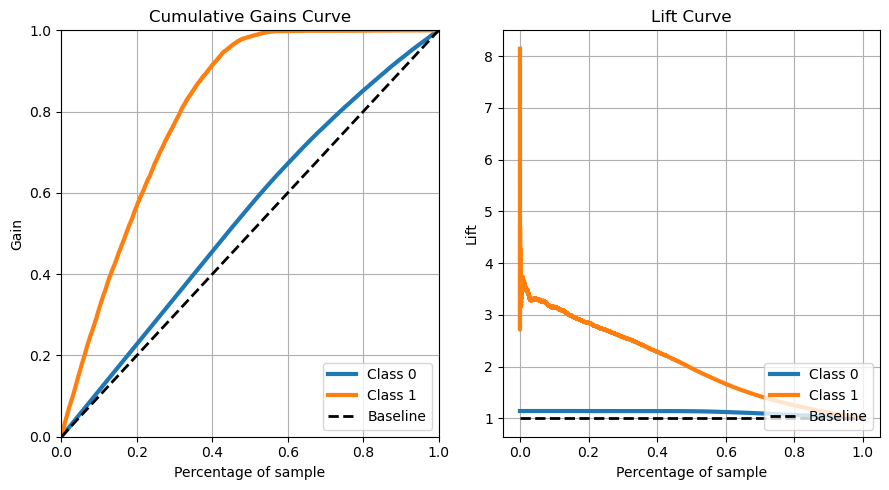

In [31]:
model_et_res = en.ExtraTreesClassifier(n_estimators=100, max_depth=10)
model_et_res.fit(x_train_res, y_train_res)
yhat_et_res = model_et.predict_proba(x_validation)

fig, axes = plt.subplots(1, 2, figsize=(9, 5))
skplt.metrics.plot_cumulative_gain(y_validation, yhat_et_res, ax=axes[0]);
skplt.metrics.plot_lift_curve(y_validation, yhat_et_res, ax=axes[1]);
plt.tight_layout()
plt.show()

# 6.0 Cross-Validation

### 6.1 Sobre dados não-balanceados

In [32]:
scoring = {'balanced_accuracy': 'balanced_accuracy',
           'precision': 'precision',
           'recall': 'recall',
           'f1': 'f1'}
scores_knn = ms.cross_validate(knn_classifier, x_train, y_train, scoring=scoring, cv=10)
scores_tree = ms.cross_validate(tree, x_train, y_train, scoring=scoring, cv=10)
scores_random = ms.cross_validate(random, x_train, y_train, scoring=scoring, cv=10)
scores_logreg = ms.cross_validate(log_reg, x_train, y_train, scoring=scoring, cv=10)
scores_xgb = ms.cross_validate(model_xgb, x_train, y_train, scoring=scoring, cv=10)
scores_et = ms.cross_validate(model_et, x_train, y_train, scoring=scoring, cv=10)

In [33]:
knn_score = scores(scores_knn, 'KNN')
tree_score = scores(scores_tree, 'DecisionTree')
random_score = scores(scores_random, 'RandomForest')
logreg_score = scores(scores_logreg, 'LogisticRegression')
xgb_score = scores(scores_xgb, 'XGBoost')
et_score = scores(scores_et, 'ExtraTrees')

result = pd.concat([knn_score, tree_score, random_score, logreg_score, xgb_score, et_score], ignore_index=True)
result

,Model,Balanced_Accuracy,Precision,Recall,F1 Score
0,KNN,0.549,0.329,0.136,0.192
1,DecisionTree,0.500,0.020,0.000,0.000
2,RandomForest,0.500,0.250,0.000,0.000
3,LogisticRegression,0.500,0.000,0.000,0.000
4,XGBoost,0.524,0.378,0.062,0.106
5,ExtraTrees,0.500,0.376,0.000,0.001


### 6.2 Sobre dados balanceados

In [34]:
scoring = {'balanced_accuracy': 'balanced_accuracy',
           'precision': 'precision',
           'recall': 'recall',
           'f1': 'f1'}
scores_knn_res = ms.cross_validate(knn_classifier_res, x_train_res, y_train_res, scoring=scoring, cv=10)
scores_tree_res = ms.cross_validate(tree_res, x_train_res, y_train_res, scoring=scoring, cv=10)
scores_random_res = ms.cross_validate(random_res, x_train_res, y_train_res, scoring=scoring, cv=10)
scores_logreg_res = ms.cross_validate(log_reg_res, x_train_res, y_train_res, scoring=scoring, cv=10)
scores_xgb_res = ms.cross_validate(model_xgb_res, x_train_res, y_train_res, scoring=scoring, cv=10)
scores_et_res = ms.cross_validate(model_et_res, x_train_res, y_train_res, scoring=scoring, cv=10)

In [35]:
knn_score_res = scores(scores_knn_res, 'KNN')
tree_score_res = scores(scores_tree_res, 'DecisionTree')
random_score_res = scores(scores_random_res, 'RandomForest')
logreg_score_res = scores(scores_logreg_res, 'LogisticRegression')
xgb_score_res = scores(scores_xgb_res, 'XGBoost')
et_score_res = scores(scores_et_res, 'ExtraTrees')

result_res = pd.concat([knn_score_res, tree_score_res, random_score_res, logreg_score_res, xgb_score_res, et_score_res], ignore_index=True)
result_res

,Model,Balanced_Accuracy,Precision,Recall,F1 Score
0,KNN,0.859,0.790,0.977,0.874
1,DecisionTree,0.835,0.788,0.914,0.846
2,RandomForest,0.919,0.916,0.923,0.911
3,LogisticRegression,0.790,0.711,0.980,0.824
4,XGBoost,0.886,0.896,0.868,0.866
5,ExtraTrees,0.807,0.733,0.967,0.834


# 7.0 Fine tuning 

In [30]:
param = {
    'max_depth': np.arange(1, 60),
    'n_estimators': np.arange(1, 200)
    }
    
random = en.RandomForestClassifier() 
scoring = {'balanced_accuracy': 'balanced_accuracy',
           'precision': 'precision',
           'recall': 'recall',
           'f1': 'f1'}
    
random_search = ms.RandomizedSearchCV(random, param_distributions=param, n_iter=20, scoring=scoring, refit='balanced_accuracy', random_state=0)
random_search.fit(x_train_res, y_train_res)

RandomizedSearchCV(estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59]),
                                        'n_estimators': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,...
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
       183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195,
       196, 197, 198, 199])},
                   random_state=0, refit='balanced_accuracy',
                   scoring={'balanced_accuracy': 'balanced_accuracy',
                            'f1': 'f1', 'precision': 'precision',
                            'recall': 'recall'})

In [31]:
random_search.best_params_

{'n_estimators': 179, 'max_depth': 52}

In [35]:
cvres = random_search.cv_results_
best_index = random_search.best_index_

best_bal_acc = cvres['mean_test_balanced_accuracy'][best_index]
best_precision = cvres['mean_test_precision'][best_index]
best_recall = cvres['mean_test_recall'][best_index]
best_f1 = cvres['mean_test_f1'][best_index]

print('Best Balanced Accuracy: {:.4f}'.format(best_bal_acc))
print('Best Precision: {:.4f}'.format(best_precision))
print('Best Recall: {:.4f}'.format(best_recall))
print('Best F1 Score:{:.4f}'.format(best_f1))

Best Balanced Accuracy: 0.9113
Best Precision: 0.9129
Best Recall: 0.9127
Best F1 Score:0.9035


### 7.1 Final model

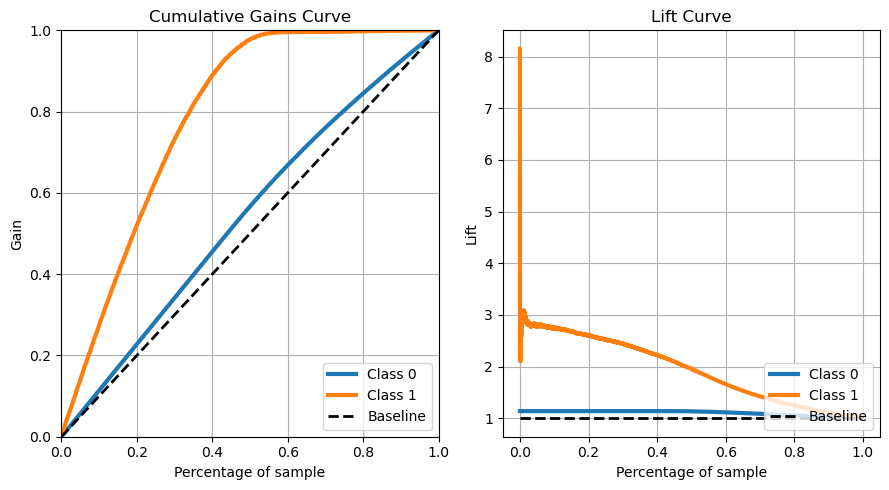

In [17]:
random_final = en.RandomForestClassifier(max_depth=52, n_estimators=179, random_state=0)
random_final.fit(x_train_res, y_train_res)
yhat_random_final = random_final.predict_proba(x_validation)

fig, axes = plt.subplots(1, 2, figsize=(9, 5))
skplt.metrics.plot_cumulative_gain(y_validation, yhat_random_final, ax=axes[0]);
skplt.metrics.plot_lift_curve(y_validation, yhat_random_final, ax=axes[1]);
plt.tight_layout()
plt.show()

In [22]:
aux = x_validation.copy()
aux['response'] = y_validation.copy()
aux['score'] = yhat_random_final[:, 1].tolist()
aux['id'] = aux.index

aux = aux.sort_values('score', ascending=False)

precision_at_k = precision_at_k(aux, 20000)
print('Precision at k: {:.4f}'.format(precision_at_k))
recall_at_k = recall_at_k(aux, 20000)
print('Recall at k: {:.4f}'.format(recall_at_k))

Precision at k: 0.3010
Recall at k: 0.6483


In [23]:
# transformando os 'score' em binários
yhat_binary = (yhat_random_final[:, 1] >= 0.5).astype(int)

balanced_accuracy = mt.balanced_accuracy_score(y_validation, yhat_binary)
f1 = mt.f1_score(y_validation, yhat_binary)

print('Balanced accuracy: {:.4f}'.format(balanced_accuracy))
print('F1 score: {:.4f}'.format(f1))

Balanced accuracy: 0.6118
F1 score: 0.3202


# 8.0 Business Performance

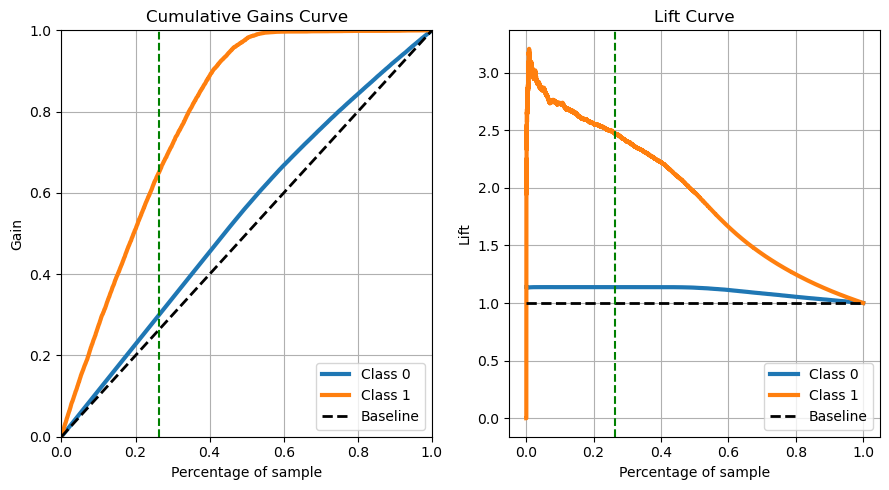

In [42]:
sample = 20000 / len(aux)

fig, axes = plt.subplots(1, 2, figsize=(9, 5))
skplt.metrics.plot_cumulative_gain(y_validation, yhat_random_final, ax=axes[0]);
skplt.metrics.plot_lift_curve(y_validation, yhat_random_final, ax=axes[1]);
axes[0].axvline(sample, color='g', linestyle='--')
axes[1].axvline(sample, color='g', linestyle='--')
plt.tight_layout()
plt.show()

In [ ]:
Em uma escolha aleatória de clientes (baseline) pelo time de vendas, fazendo as 20000 ligações, apenas 26% dos possíveis 
interessados em adquirir o seguro seriam contactados. Já em uma escolha seguindo o modelo ML (Class1), o time de vendas 
contactaria quase 65% dos interessados. Ou seja, o resultado do modelo é 2,5 vezes melhor que uma escolha aleatória.

In [ ]:
Considerando que o valor do seguro veicular seja na faixa de 1500, para as porcentagens descritas acima, o modelo fatura 
aproximadamente 44 milhões a mais que a baseline.

In [59]:
sample_baseline = 0.262 * len(aux)
sample_model = 0.648 * len(aux)

fat_baseline = int(sample_baseline) * 1500
fat_model = int(sample_model) * 1500

diferenca = fat_model - fat_baseline
diferenca

44131500

# 9.0 Deploy do modelo em produção

In [18]:
# salvando o modelo treinado
pickle.dump(random_final, open('/Users/lehre/Desktop/CIENCIA_DADOS/ComunidadeDS/REPOS/propensao-compra/api/model/model_health_insurance.pkl', 'wb'))

In [19]:
pickle.dump(ss, open('/Users/lehre/Desktop/CIENCIA_DADOS/ComunidadeDS/REPOS/propensao-compra/api/features/annual_premium_scaler.pkl', 'wb'))
pickle.dump(mms_age, open('/Users/lehre/Desktop/CIENCIA_DADOS/ComunidadeDS/REPOS/propensao-compra/api/features/age_scaler.pkl', 'wb'))
pickle.dump(mms_vintage, open('/Users/lehre/Desktop/CIENCIA_DADOS/ComunidadeDS/REPOS/propensao-compra/api/features/vintage_scaler.pkl', 'wb'))
pickle.dump(fe_policy_sales_channel, open('/Users/lehre/Desktop/CIENCIA_DADOS/ComunidadeDS/REPOS/propensao-compra/api/features/fe_policy_sales_channel_scaler.pkl', 'wb'))
pickle.dump(fe_region_code, open('/Users/lehre/Desktop/CIENCIA_DADOS/ComunidadeDS/REPOS/propensao-compra/api/features/fe_region_code_scaler.pkl', 'wb'))

### 9.1 Health Insurance Class

In [32]:
import pickle
import numpy  as np
import pandas as pd

class HealthInsuranceClass:

    def __init__(self):
        self.home_path                      = '/Users/lehre/Desktop/CIENCIA_DADOS/ComunidadeDS/REPOS/propensao-compra/'
        self.annual_premium_scaler          = pickle.load(open(self.home_path + 'api/features/annual_premium_scaler.pkl','rb'))
        self.age_scaler                     = pickle.load(open(self.home_path + 'api/features/age_scaler.pkl','rb'))
        self.vintage_scaler                 = pickle.load(open(self.home_path + 'api/features/vintage_scaler.pkl','rb'))
        self.fe_policy_sales_channel_scaler = pickle.load(open(self.home_path + 'api/features/fe_policy_sales_channel_scaler.pkl','rb'))
        self.fe_region_code_scaler          = pickle.load(open(self.home_path + 'api/features/fe_region_code_scaler.pkl','rb'))
     
    def data_cleaning(self, df):
        cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age',
                    'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage', 'response']
        df.columns = cols_new
        
        return df
    
    def feature_engineering(self, df):
        df['vehicle_age'] = df['vehicle_age'].apply(lambda x: 'over 2 years' if x == '> 2 Years' else '1-2 year' if x == '1-2 Year' else 'bellow 1 year')
        df['vehicle_damage'] = df['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)
        df['gender'] = df['gender'].apply(lambda x: 1 if x == 'Male' else 0)
        
        return df
    
    def data_preparation(self, df):
        df = pd.get_dummies(df, columns=['vehicle_age'], dtype=int)
        df['annual_premium'] = self.annual_premium_scaler.transform(df[['annual_premium']].values)
        df['age'] = self.age_scaler.transform(df[['age']].values)
        df['vintage'] = self.vintage_scaler.transform(df[['vintage']].values)       
        df.loc[:, 'policy_sales_channel'] = df['policy_sales_channel'].map(self.fe_policy_sales_channel_scaler) 
        df.loc[:, 'region_code'] = df['region_code'].map(self.fe_region_code_scaler)

        cols_selected = ['age', 'region_code', 'previously_insured', 'vehicle_damage', 'annual_premium', 
                 'policy_sales_channel', 'vintage']
        
        return df[cols_selected]
    
    def get_prediction(self, model, original_data, test_data):
        
        pred = model.predict_proba(test_data)
        
        original_data['score'] = pred[:,1]
        
        return original_data.to_json(orient='records', date_format='iso')

In [ ]:
def data_cleaning(df):
        cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age',
                    'vehicle_damage', 'annual_premium', 'policy_sales_channel', 'vintage', 'response']
        df.columns = cols_new
        
        return df

In [41]:
def feature_engineering(df):
        df['vehicle_age'] = df['vehicle_age'].apply(lambda x: 'over 2 years' if x == '> 2 Years' else '1-2 year' if x == '1-2 Year' else 'bellow 1 year')
        df['vehicle_damage'] = df['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)
        df['gender'] = df['gender'].apply(lambda x: 1 if x == 'Male' else 0)
        
        return df

In [69]:
home_path                      = '/Users/lehre/Desktop/CIENCIA_DADOS/ComunidadeDS/REPOS/propensao-compra/'
annual_premium_scaler          = pickle.load(open(home_path + 'api/features/annual_premium_scaler.pkl','rb'))
age_scaler                     = pickle.load(open(home_path + 'api/features/age_scaler.pkl','rb'))
vintage_scaler                 = pickle.load(open(home_path + 'api/features/vintage_scaler.pkl','rb'))
fe_policy_sales_channel_scaler = pickle.load(open(home_path + 'api/features/fe_policy_sales_channel_scaler.pkl','rb'))
fe_region_code_scaler          = pickle.load(open(home_path + 'api/features/fe_region_code_scaler.pkl','rb'))
model = pickle.load(open(home_path + 'api/model/model_health_insurance.pkl', 'rb'))

In [58]:
def data_preparation(df):
        df = pd.get_dummies(df, columns=['vehicle_age'], dtype=int)
        df['annual_premium'] = annual_premium_scaler.transform(df[['annual_premium']].values)
        df['age'] = age_scaler.transform(df[['age']].values)
        df['vintage'] = vintage_scaler.transform(df[['vintage']].values)       
        df.loc[:, 'policy_sales_channel'] = df['policy_sales_channel'].map(fe_policy_sales_channel_scaler) 
        df.loc[:, 'region_code'] = df['region_code'].map(fe_region_code_scaler)

        cols_selected = ['age', 'region_code', 'previously_insured', 'vehicle_damage', 'annual_premium', 
                 'policy_sales_channel', 'vintage']
        
        return df[cols_selected]

In [33]:
def get_prediction(model, original_data, test_data):
        
        pred = model.predict_proba(test_data)
        
        original_data['score'] = pred[:,1]
        
        return original_data.to_json(orient='records', date_format='iso')

In [34]:
get_prediction(model, df_raw, df1)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- driving_license
- gender
- id
- response
- vehicle_age


### 9.2 API Handler

In [35]:
import pandas as pd
import pickle
import json
from flask import Flask, request, Response
from healthinsuranceclass import HealthInsuranceClass

# loading model
path = '/Users/lehre/Desktop/CIENCIA_DADOS/ComunidadeDS/REPOS/propensao-compra/'
model = pickle.load(open(path + 'api/model/model_health_insurance.pkl', 'rb'))

# initializing API
app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def health_insurance_predict():
    test_json = request.get_json()
    if test_json:
        if isinstance(test_json, dict):
            test_raw = pd.DataFrame(test_json, index=[0])  
        else:
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
        
        # instantiate HealthInsurance class
        pipeline = HealthInsuranceClass()
        
        df1 = pipeline.data_cleaning(test_raw)
        df2 = pipeline.feature_engineering(df1)
        df3 = pipeline.data_preparation(df2)
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response
    
    else:
        return Response('{}', status=200, mimetype='application/json')
    
if __name__ == '__main__':
        app.run('127.0.0.1', port=5000, debug=True)
    #    app.run('0.0.0.0', port=5000, debug=False, use_reloader=False)

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with watchdog (windowsapi)


SystemExit: 1

### 9.3 API Tester

In [45]:
import requests

df_test = x_validation[cols_selected]
df_test = df_test.sample(10)

# convert dataframe to json
data = json.dumps(df_test.to_dict(orient='records'))

# API Call
url = 'http://127.0.0.1:5000/predict'
header = {'Content-type':'application/json'}
data = data

r = requests.post(url, data=data, headers=header)
print('Status Code {}'.format(r.status_code))

Status Code 500


In [58]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())
#d1['id'] = d1.index
d1.sort_values('score', ascending=False).head()

JSONDecodeError: Expecting value: line 1 column 1 (char 0)